<a href="https://colab.research.google.com/github/AlexeyTri/MLSeminars/blob/main/HW3/HW3_woodenML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Результаты работы также должны появиться в базе данных, так как они будут переданы аналитикам компании. В результате вашей работы в базе должна быть информация от вас в двух таблицах (смотри задание в конце нотубука). Наличие информации о ваших результатах в первой таблице: student_results - блокирующее задание, без его выполнения за домашнее задание ставится 0.

Продуктивной и интересной вам работы!

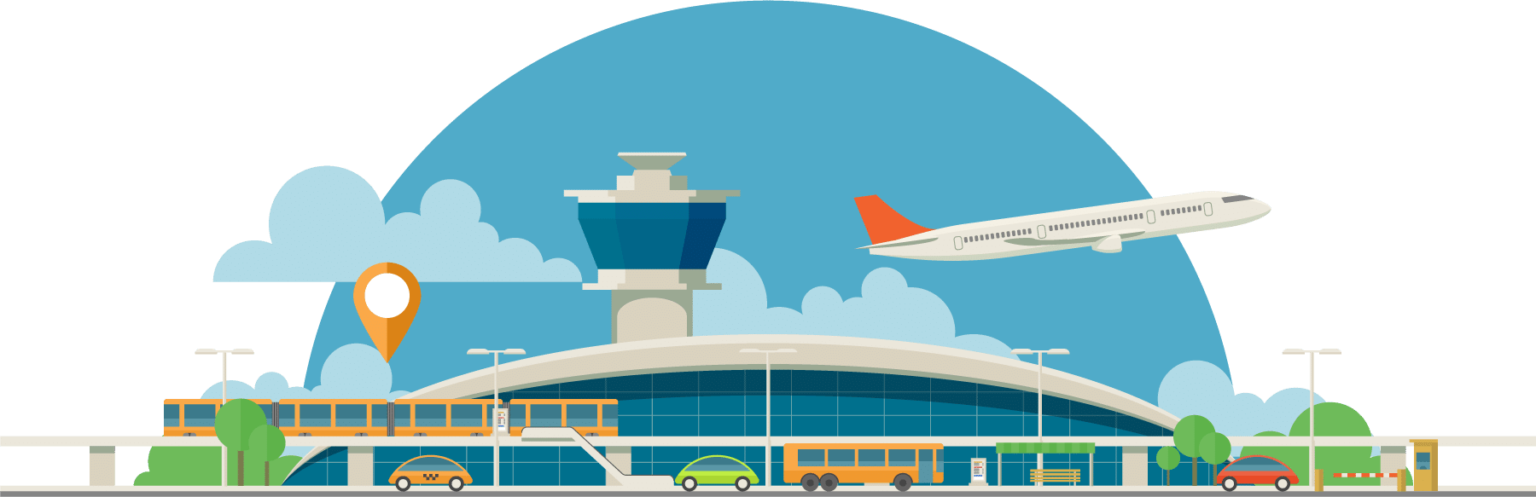

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [2]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install eli5
!pip install missingno
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import eli5
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (2.5 балла + 0.25)

## Загрузка и предобработка данных (1.5 балла)

In [4]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-14 14:00:02--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-14 14:00:03 (678 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycog2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

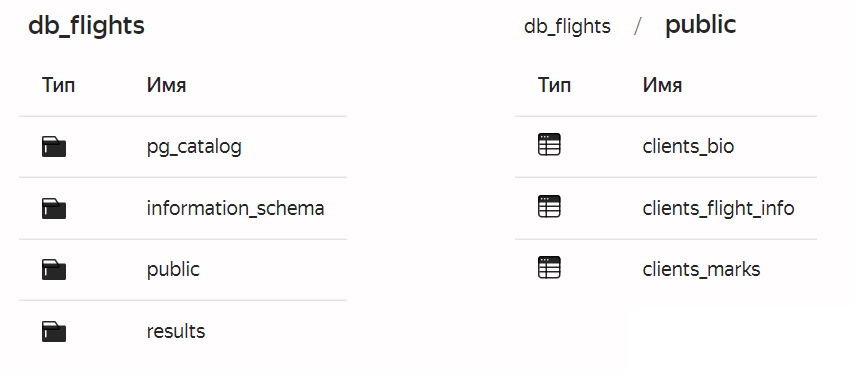

In [5]:
# your code below
try:
    conn = psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
                            port='6432',
                            sslmode='verify-full',
                            dbname='db_flights', 
                            user='mlhs_student', 
                            password='mlhs_student',                          
                            target_session_attrs='read-write')
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM clients_bio")
        df1 = pd.DataFrame(cur.fetchall(), columns=[disc[0] for disc in cur.description])
        print(f'Размер df1{df1.shape}')
        cur.execute("SELECT * FROM clients_marks")
        df2 = pd.DataFrame(cur.fetchall(), columns=[disc[0] for disc in cur.description])
        print(f'Размер df2{df2.shape}')
        cur.execute("SELECT * FROM clients_flight_info")
        df3 = pd.DataFrame(cur.fetchall(), columns=[disc[0] for disc in cur.description])
        print(f'Размер df3{df3.shape}')
except:
    print("[INFO] ERROR while working PostgreSQL")
finally:
    if conn:
        conn.close()
        print("[INFO] PostgreSQL closed")

df = df1.merge(df2, on='id').merge(df3, on='id')
new_index = df['id'].values
df = df.reindex(new_index)
df.drop(['id'],axis=1, inplace=True)

Размер df1(129549, 3)
Размер df2(129880, 16)
Размер df3(129880, 7)
[INFO] PostgreSQL closed


In [ ]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
# your code below
idx = pd.IndexSlice

In [ ]:
list_object = ['gender', 'satisfaction', 'Customer Type','Type of Travel', 'class']
list_float = list(set(df.columns) - set(list_object))

In [ ]:
# перепробовал миллиард вариантов, без этой операции список листов к float не приводит
df.iloc[:, 1] = df.iloc[:, 1].astype(np.float32())

In [ ]:
df.loc[:,list_float] = df.loc[:, list_float].astype(np.float32(), errors='ignore')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129218 non-null  object 
 1   age                                128904 non-null  float32
 2   Inflight wifi service              129174 non-null  float32
 3   Departure/Arrival time convenient  129169 non-null  float32
 4   Ease of Online booking             129175 non-null  float32
 5   Gate location                      129181 non-null  float32
 6   Food and drink                     129168 non-null  float32
 7   Online boarding                    129172 non-null  float32
 8   Seat comfort                       129171 non-null  float32
 9   Inflight entertainment             129173 non-null  float32
 10  On-board service                   129174 non-null  float32
 11  Leg room service                   1291

In [ ]:
df.replace('nan', pd.NA, inplace=True)

In [ ]:
df.dropna(how='all',inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.drop('index', axis=1, inplace=True)

In [ ]:
df.isna().sum()

gender                                 0
age                                  314
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      62
cleanliness                           37
satisfaction                           0
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           106
Arrival Delay in Minutes             505
dtype: int64

(0.25 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

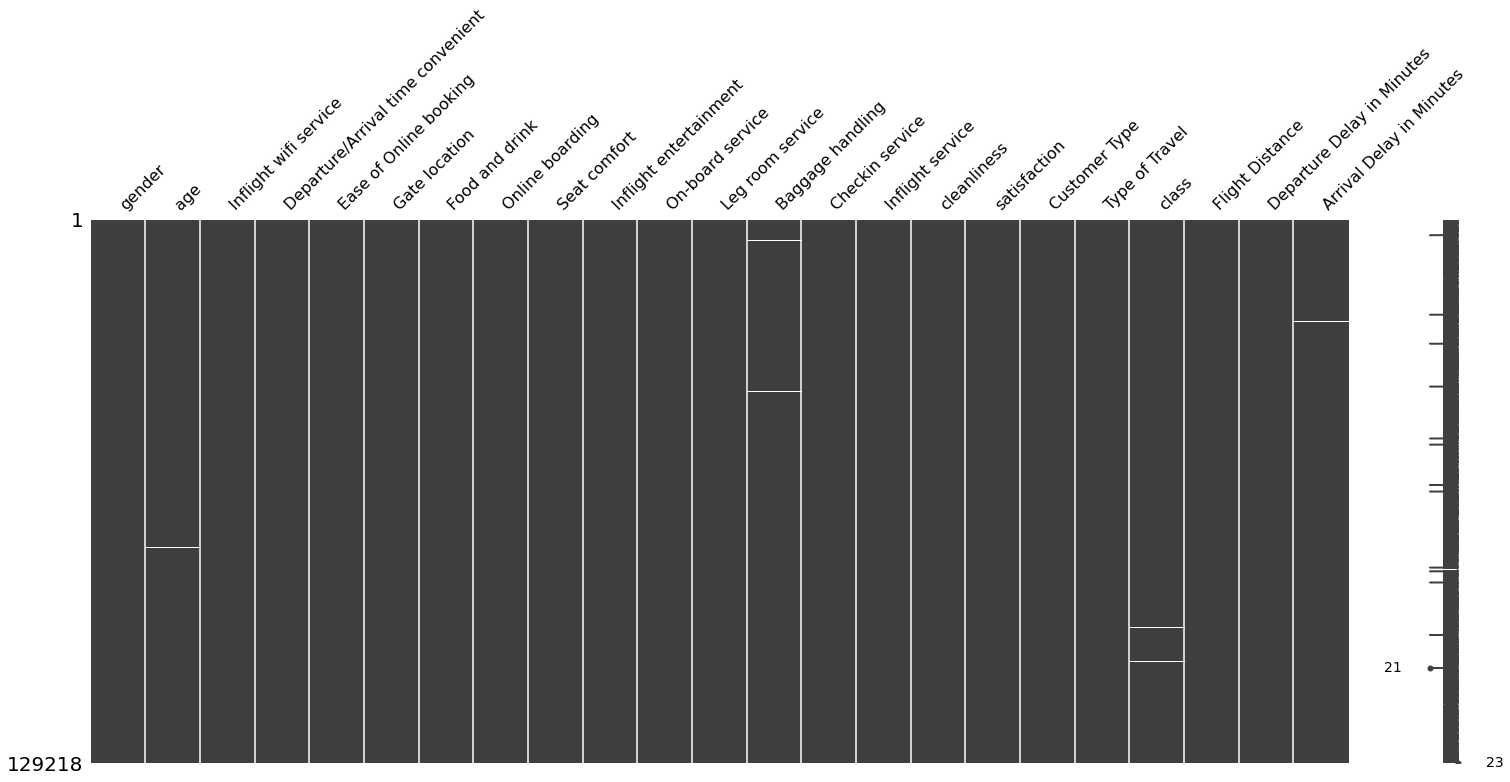

In [ ]:
# your code below
missingno.matrix(df)

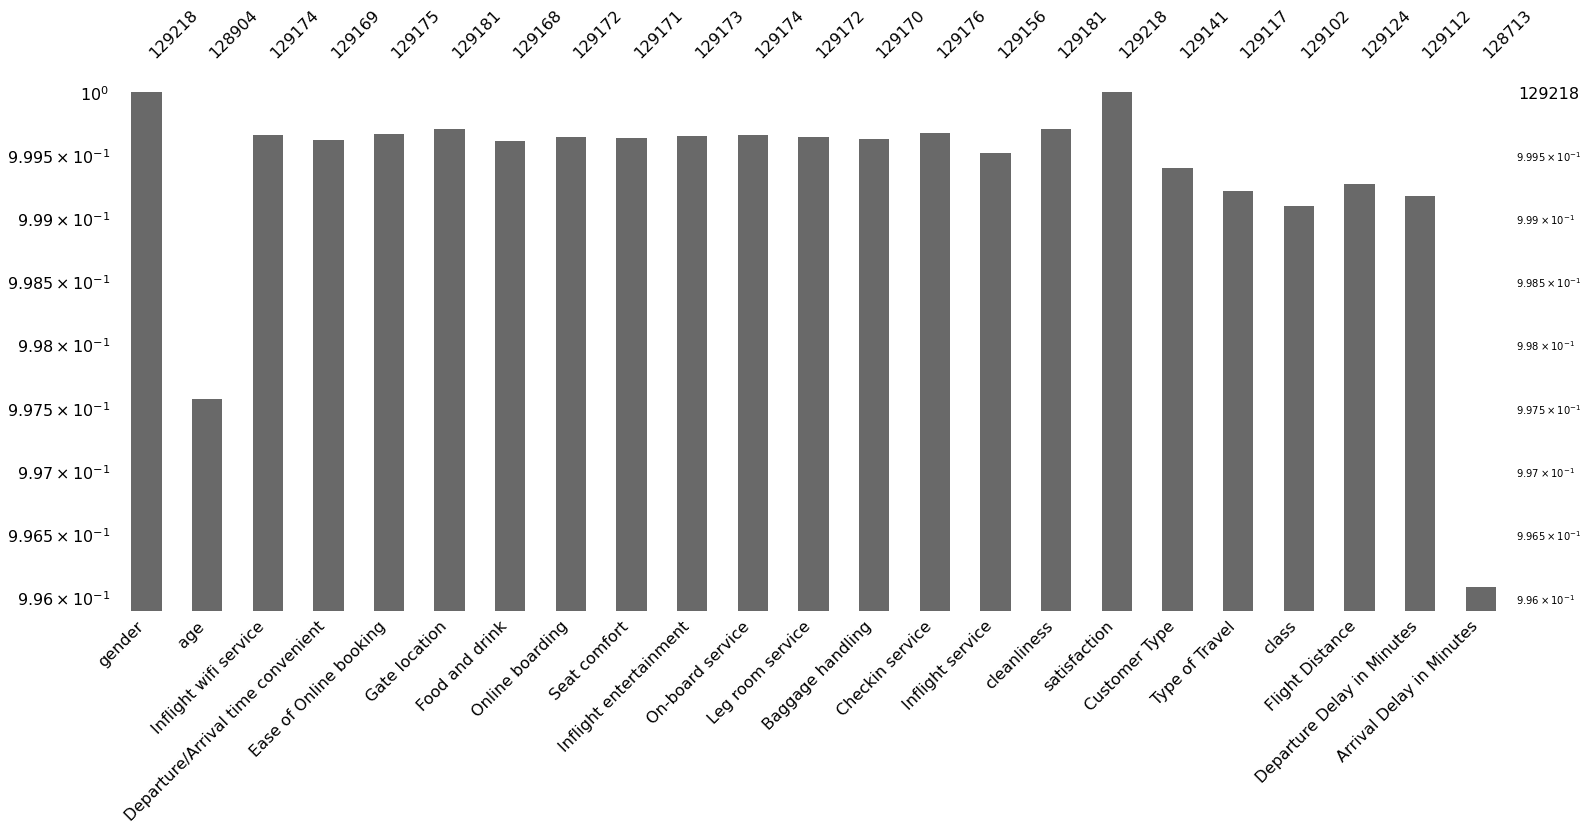

In [ ]:
# your code below
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [ ]:
df_train = df[(df.satisfaction != '-')]

In [ ]:
assert df_train.shape == (103_370, 23)

In [ ]:
df_test = df[(df.satisfaction == '-')].drop('satisfaction', axis=1)

In [ ]:
assert df_test.shape == (25_848, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_359, 22)
assert X_val.shape == (31_011, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>. 
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [ ]:
# your code below
X_mode = X_train.mode()
X_mode = X_mode.to_dict('records')[0]

In [ ]:
X_train = X_train.fillna(X_mode)
X_train.isna().sum()

gender                               0
age                                  0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

In [ ]:
X_val = X_val.fillna(X_mode)
X_val.isna().sum()

gender                               0
age                                  0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

In [ ]:
df_test = df_test.fillna(X_mode)
df_test.isna().sum()

gender                               0
age                                  0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

In [ ]:
y_mode = y_train.mode()[0]

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [ ]:
# the place for you to code
list_object.remove('satisfaction') # категориальные признаки
X_train.describe()

age  Inflight wifi service  Departure/Arrival time convenient  \
count  72359.000000           72359.000000                       72359.000000   
mean      40.041557               2.731588                           3.063669   
std       20.098490               1.362130                           1.554539   
min        0.000000               0.000000                           0.000000   
25%       27.000000               2.000000                           2.000000   
50%       40.000000               3.000000                           3.000000   
75%       51.000000               4.000000                           4.000000   
max      612.000000              45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72359.000000   72359.000000    72359.000000     72359.000000   
mean                 2.756506       2.981578        3.205337         3.254011   
std                  1.420488       1.312492        1.354653         1.384632   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 45.000000      36.000000       36.000000        40.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72359.000000            72359.000000      72359.000000   
mean       3.441783                3.360605          3.386462   
std        1.355017                1.360987          1.336959   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72359.000000      72359.000000     72359.000000      72359.000000   
mean           3.358269          3.635913         3.311516          3.646899   
std            1.367675          1.222701         1.309671          1.201328   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           40.000000         40.000000        45.000000         35.000000   

        cleanliness  Flight Distance  Departure Delay in Minutes  \
count  72359.000000     72359.000000                72359.000000   
mean       3.287843      1320.654907                   15.977239   
std        1.332288      4800.736328                   80.383781   
min        0.000000         0.000000                    0.000000   
25%        2.000000       413.000000                    0.000000   
50%        3.000000       838.000000                    0.000000   
75%        4.000000      1744.000000                   12.000000   
max       30.000000    379620.000000                11011.000000   

       Arrival Delay in Minutes  
count              72359.000000  
mean                  16.781036  
std                  106.041862  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%                   13.000000  
max                11760.000000

In [ ]:
X_train.loc[:, list_object].describe()

gender   Customer Type   Type of Travel     class
count    72359           72359            72359     72359
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36622           59189            49801     34543

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

1. континуальные признаки обладают явными вбросами, такими как возраст 612 лет
2. категориальные признаки все состоят из конечных множест из 2, либо 3-х элементов
3. остальные признаки это ранжированные оценки, соответственно подход к ним должен быть иным чем к контиуальным

In [ ]:
# answer here, feel free to change into markdown



(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах.</font> Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [ ]:
# place for you to code: 
q_columns = X_train.select_dtypes(include='number').columns
print(f'{X_train.shape} size X_train dataset before refactor')
X_train.loc[:, q_columns]= X_train.loc[:, q_columns][X_train.loc[:, q_columns] < X_train.loc[:, q_columns].quantile(0.996)]
X_mode = X_train.mode()
X_mode = X_mode.to_dict('records')[0]
X_train.fillna(X_mode, inplace=True)
print(f'{X_train.shape} size X_train dataset after refactor')

(72359, 22) size X_train dataset before refactor
(72359, 22) size X_train dataset after refactor


In [ ]:
y_train = y_train[X_train.index]

In [ ]:
print(f'{X_val.shape} size X_val dataset before refactor')
X_val.loc[:, q_columns]= X_val.loc[:, q_columns][X_val.loc[:, q_columns] < X_val.loc[:, q_columns].quantile(0.996)]
X_val.fillna(X_mode, inplace=True)
print(f'{X_val.shape} size X_val dataset after refactor')

y_val = y_val[X_val.index]

(31011, 22) size X_val dataset before refactor
(31011, 22) size X_val dataset after refactor


In [ ]:
print(f'{df_test.shape} size df_test dataset before refactor')
df_test.loc[:, q_columns]= df_test.loc[:, q_columns][df_test.loc[:, q_columns] < df_test.loc[:, q_columns].quantile(0.996)]
df_test.fillna(df_test, inplace=True)
print(f'{df_test.shape} size df_test dataset after refactor')

(25848, 22) size df_test dataset before refactor
(25848, 22) size df_test dataset after refactor


In [ ]:
assert X_train.shape == (72_359, 22)
assert X_val.shape == (31_011, 22)
assert df_test.shape == (25_848, 22)

## EDA (1 балл + 0.25)

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns.drop('satisfaction')) 

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
def plot_ordinal(cols: ordinal_cols, df, y) -> ordinal_cols:
    """Draws countplots for all columns in 'cols' with informative title"""
    df_plot = df.loc[:, cols].join(y)
    fg = plt.figure(figsize=(15,120))
    fg.autofmt_xdate(rotation=90)
    gs = GridSpec(len(cols), 1)
    ax = []
    for idx, i in enumerate(cols):
        ax.append(fg.add_subplot(gs[idx, 0]))
        sns.countplot(data=df_plot, x=i, hue="satisfaction", ax=ax[idx])
        plt.title(r'{} distribution'.format(i))
        plt.ylabel('count')
    plt.show()   


In [ ]:
def plot_continuous(cols: continuous_cols, df, y) -> continuous_cols:
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    df_plot = df.loc[:, cols].join(y)
    for idx, i in enumerate(cols):
        fg, (ax1, ax2) = plt.subplots(1, 2, sharex=False)
        sns.kdeplot(data=df_plot,x=df_plot.loc[:, i],hue='satisfaction', ax=ax1)
        plt.title(r'{} distribution'.format(i))
        plt.legend(loc='lower center')
        sns.boxplot(data=df_plot,x=df_plot.loc[:, i],y=df_plot.loc[:, 'satisfaction'], hue='satisfaction', ax=ax2)
        plt.title(r'{} boxplot by target'.format(i))
        ax2.get_legend().remove()
    plt.show() 

In [ ]:
def plot_categorical(cols: categorical_cols, df, y) -> categorical_cols:
    """Draws countplots for all columns in 'cols' with informative title"""
    df_plot = df.loc[:, cols].join(y)
    fg = plt.figure(figsize=(15,45))
    fg.autofmt_xdate(rotation=90)
    gs = GridSpec(len(cols), 1)
    ax = []
    for idx, i in enumerate(cols):
        ax.append(fg.add_subplot(gs[idx, 0]))
        df_plot.groupby(i)[y.name].value_counts().unstack().plot.bar(ax=ax[idx])
        ax[idx].tick_params(axis='x', labelrotation=0)
        plt.title(r'{} distribution'.format(i))
        plt.ylabel('count')
    plt.show()        

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

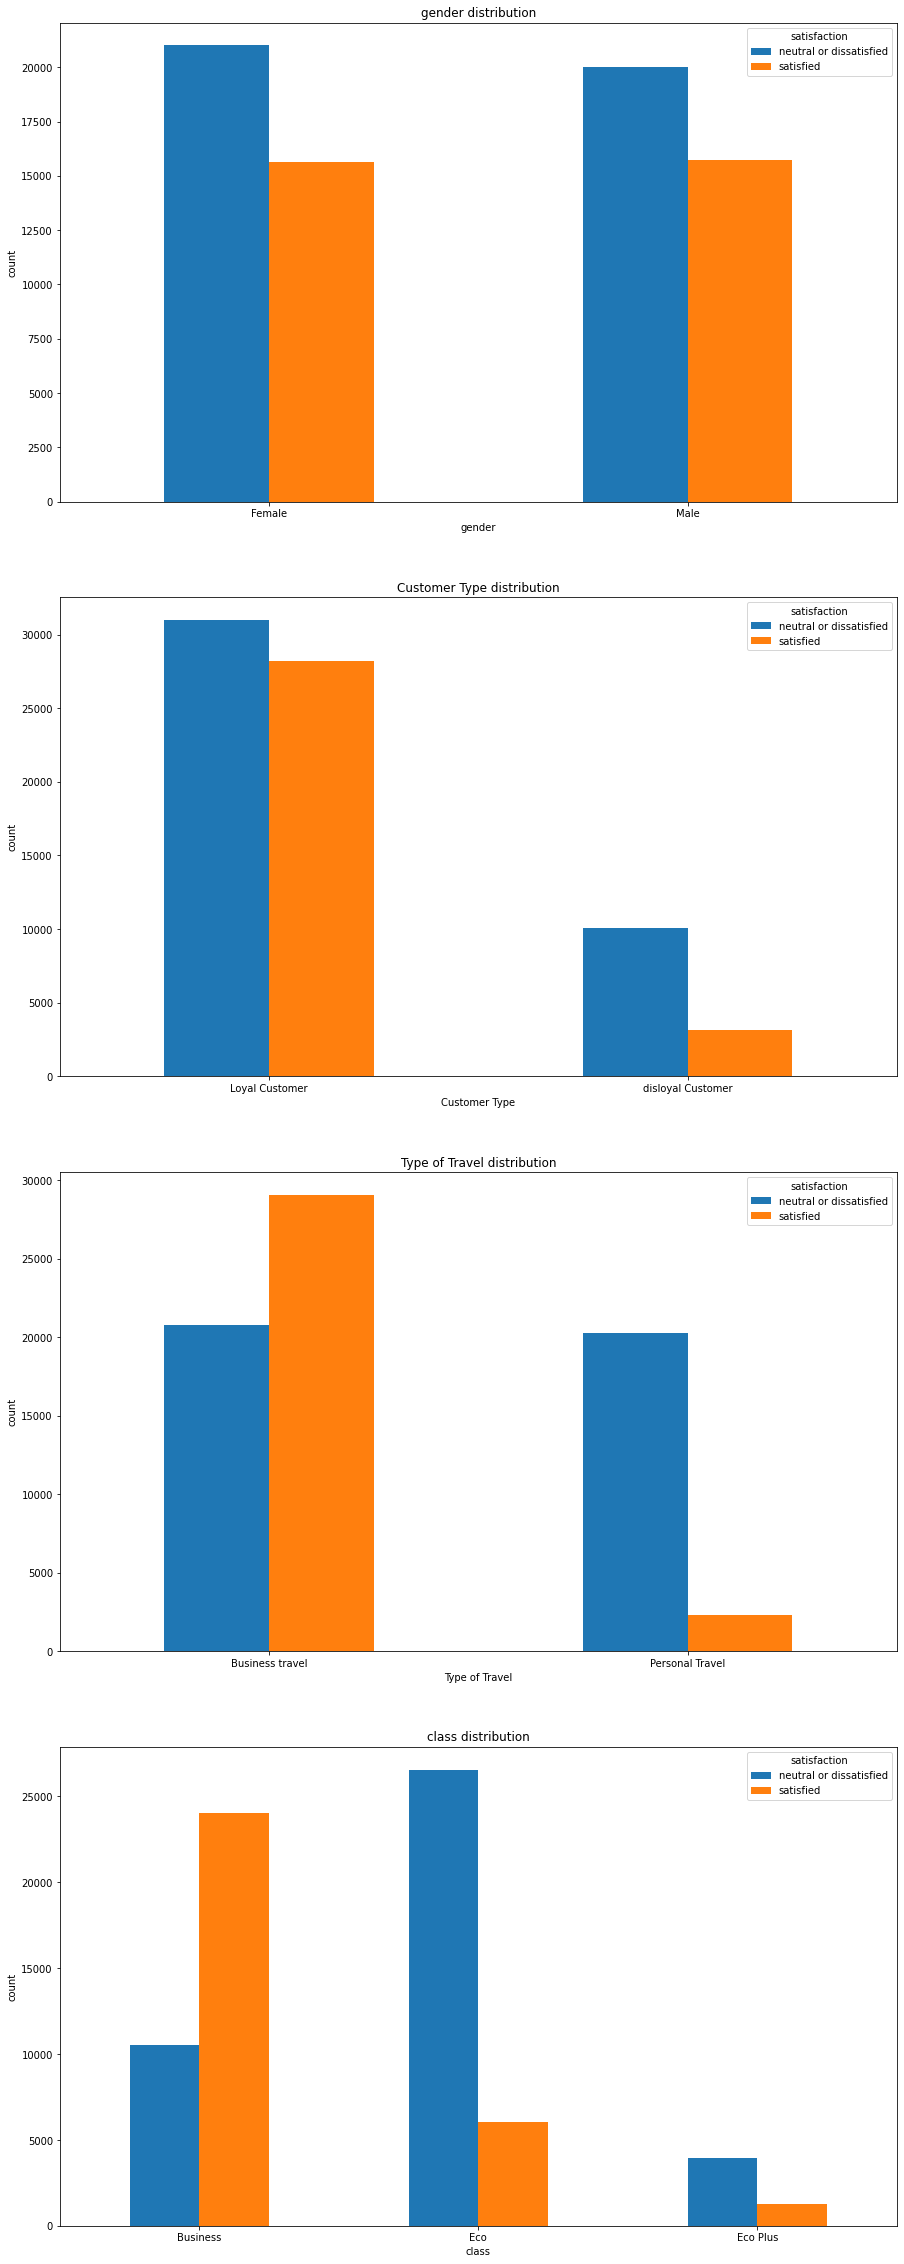

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

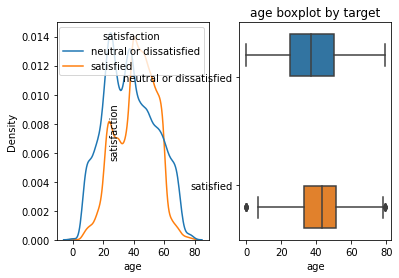

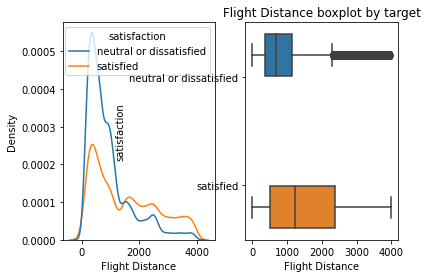

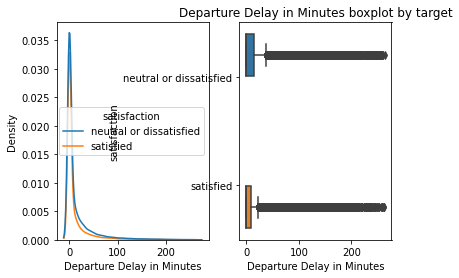

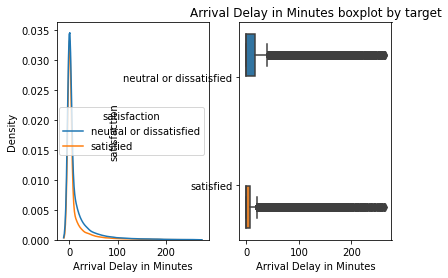

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

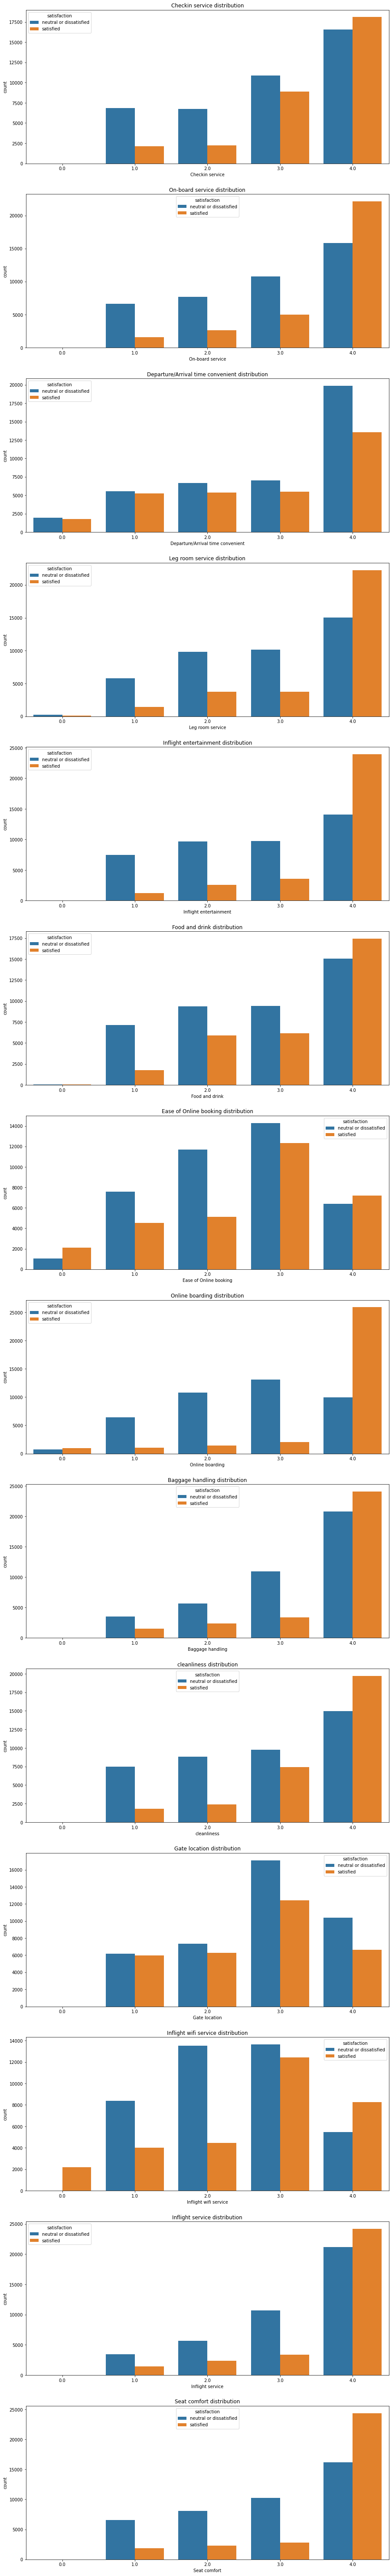

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


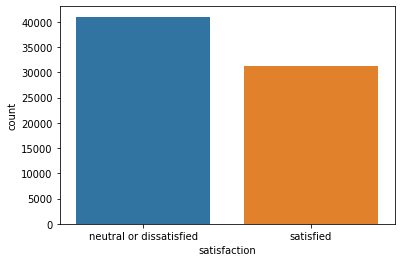

In [ ]:
# visualize y_train
sns.countplot(y_train)

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:

* какие признаки распределены неравномерно -** все признаки распределены неравномерно**
* сбалансированы ли классы - **нет, класс "нейтральное отношение" более часто встречающийся**
* какие распределения имеют континуальные признаки - это нормальное распределение но с смещенной оценкой и большими хвостами вбросов

In [ ]:
# your answer her
# feel free to change this cell from code to markdown



(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

In [ ]:
# your code below



(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [ ]:
# your code
X_train.loc[:, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = np.log1p(X_train.loc[:, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']])
X_val.loc[:, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = np.log1p(X_val.loc[:, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']])

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

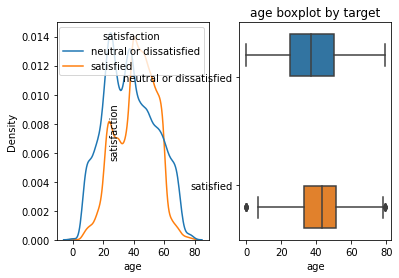

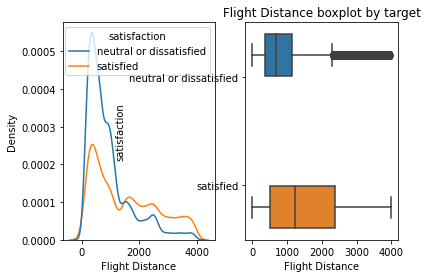

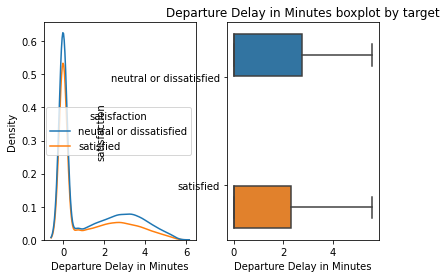

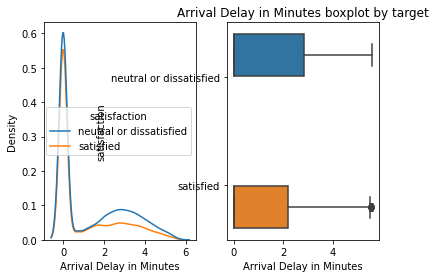

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [ ]:
# your code
y_train.replace({'satisfied':1, 'neutral or dissatisfied': 0},inplace=True)
y_val.replace({'satisfied':1, 'neutral or dissatisfied': 0},inplace=True)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

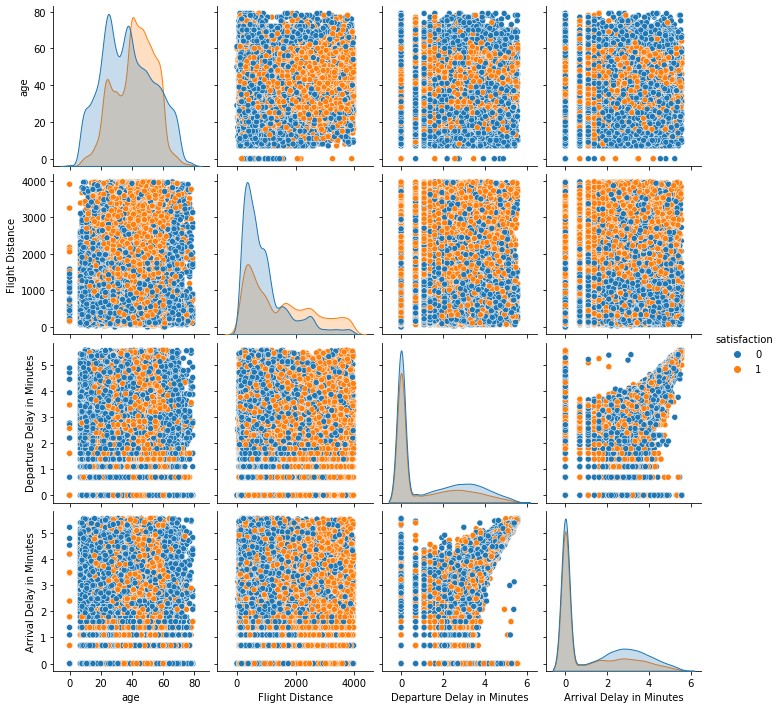

In [ ]:
# your code
df_plot = X_train.loc[:, continuous_cols].join(y_train)
sns.pairplot(df_plot, hue='satisfaction')

<font color='#9933CC'>Отобразите тепловую карту корреляций признаков и таргета</font>

In [ ]:
# code below
sns.heatmap(X_train[continuous_cols], annot=True)

Видим, что с целевой переменной ни у одного признака нет выраженной корреляции. Самая большая у 'Online boarding'. Дальше проверим, информативен ли этот признак для предсказания удовлетворенности

<img src='https://mobimg.b-cdn.net/v3/fetch/fe/fe22186dba2df35f07573604aa8a0e63.jpeg?w=1470&r=0.5625' height=500px>

# Decision Tree (1.75 балла)

(0.25 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [ ]:
# your code below
one_hot_enc = OneHotEncoder(drop='first')
print(f'{X_train.shape} X_train.shape before refactor')
X_OHE = one_hot_enc.fit_transform(X_train.loc[:, categorical_cols]).toarray()
name = one_hot_enc.get_feature_names_out(X_train.loc[:, categorical_cols].columns)
X_new_cat = pd.DataFrame(X_OHE,columns=name, index=X_train.index)
X_train.drop(categorical_cols, axis=1, inplace=True)
X_train = X_train.join(X_new_cat, how='right')
print(f'{X_train.shape} X_train.shape after refactor')

(72359, 22) X_train.shape before refactor
(72359, 23) X_train.shape after refactor


In [ ]:
print(f'{X_val.shape} X_train.shape before refactor')
X_OHE = one_hot_enc.fit_transform(X_val.loc[:, categorical_cols]).toarray()
name = one_hot_enc.get_feature_names_out(X_val.loc[:, categorical_cols].columns)
X_new_cat = pd.DataFrame(X_OHE,columns=name, index=X_val.index)
X_val.drop(categorical_cols, axis=1, inplace=True)
X_val = X_val.join(X_new_cat, how='right')
print(f'{X_val.shape} X_train.shape after refactor')

(31011, 22) X_train.shape before refactor
(31011, 23) X_train.shape after refactor


<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для теста

In [ ]:
# code here
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
accuracy_score(y_val, dtc.predict(X_val))

0.9209312824481636

## Деревья решений. Теоретическая вставка

(0.25 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# change *params into what needs to be there by task condition

error_dt, bias_dt, var_dt = bias_variance_decomp(dtc, X_train=X_train.values, y_train=y_train.values, X_test=X_val.values, y_test=y_val.values, loss='0-1_loss',random_seed=42)
error_dt, bias_dt, var_dt

(0.08414223985037568, 0.056076875947244524, 0.06043452323369127)

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

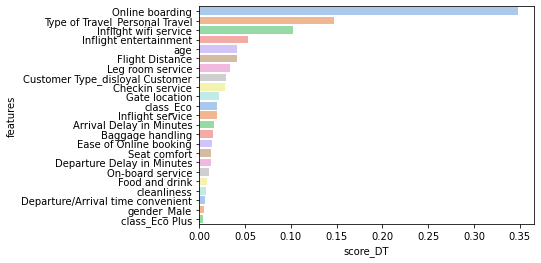

In [ ]:
# the place for your code
df_features = pd.DataFrame(dtc.feature_importances_,columns=['score_DT'])
features = pd.DataFrame(X_train.columns,columns=['features'])
features = features.join(df_features, how='right')
features.sort_values(by='score_DT', ascending=False, inplace=True)
sns.barplot(
    data=features, x="score_DT", y="features"
    , capsize=.4, palette ="pastel")


<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

см. график

In [ ]:
# your answer below
# feel free to change this cell into markdown



<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [ ]:
print(f'глубина дерева :{dtc.tree_.max_depth}, количество листьев :{dtc.tree_.n_leaves}')

глубина дерева :33, количество листьев :4141


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

на 10 пунктов

In [ ]:
# the place for your solution
dtc_new = DecisionTreeClassifier(max_depth=5)

X_train_new = X_train.loc[:, ['Online boarding', 'Type of Travel_Personal Travel']]
dtc_new.fit(X_train_new, y_train)


X_val_new = X_val.loc[:, ['Online boarding', 'Type of Travel_Personal Travel']]
accuracy_score(y_val,dtc_new.predict(X_val_new))

0.8489568217729193

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

In [ ]:
# feel free to google
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import tree
import graphviz

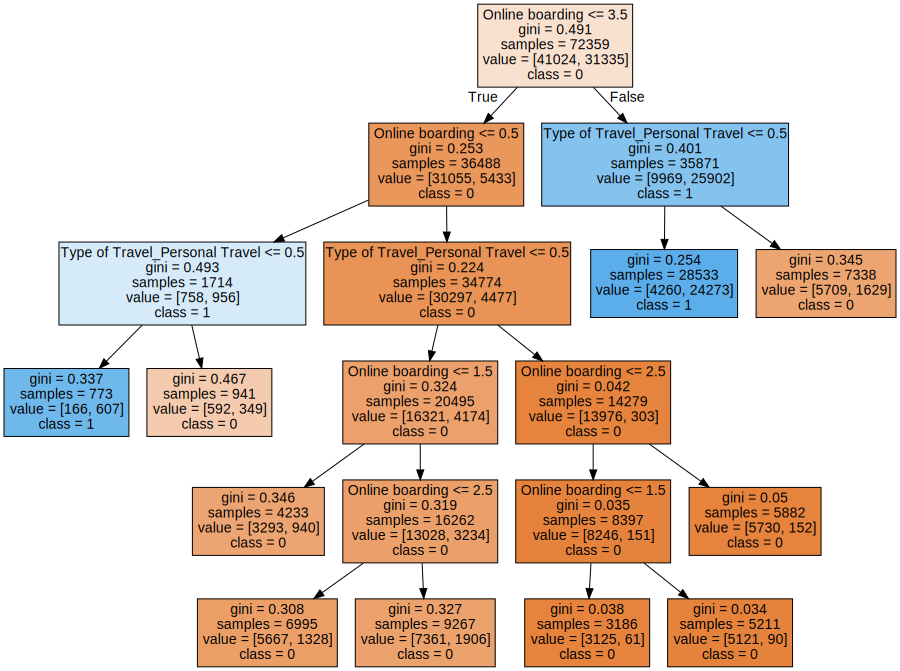

In [ ]:
dot_data = tree.export_graphviz(dtc_new, 
                                out_file=None, 
                                feature_names=X_train_new.columns,  
                                class_names=['0', '1'],
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договореённости) признаков</font>

In [ ]:
# your code below
dtc_new_con = DecisionTreeClassifier(max_depth=5)

X_train_new_con = X_train.loc[:, ['age','Flight Distance']]
dtc_new_con.fit(X_train_new_con, y_train)


X_val_new_con = X_val.loc[:, ['age','Flight Distance']]
accuracy_score(y_val,dtc_new_con.predict(X_val_new_con))

0.6773402986037212

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

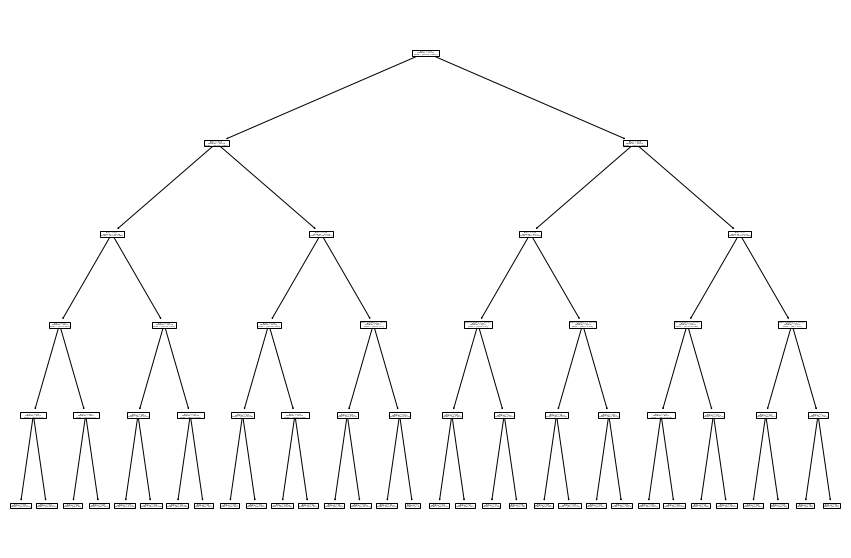

In [ ]:
# another place to code a few lines
plt.figure(figsize=(15,10))
plot_tree(dtc_new_con,feature_names= X_train_new_con.columns)
plt.show()

(0.25 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


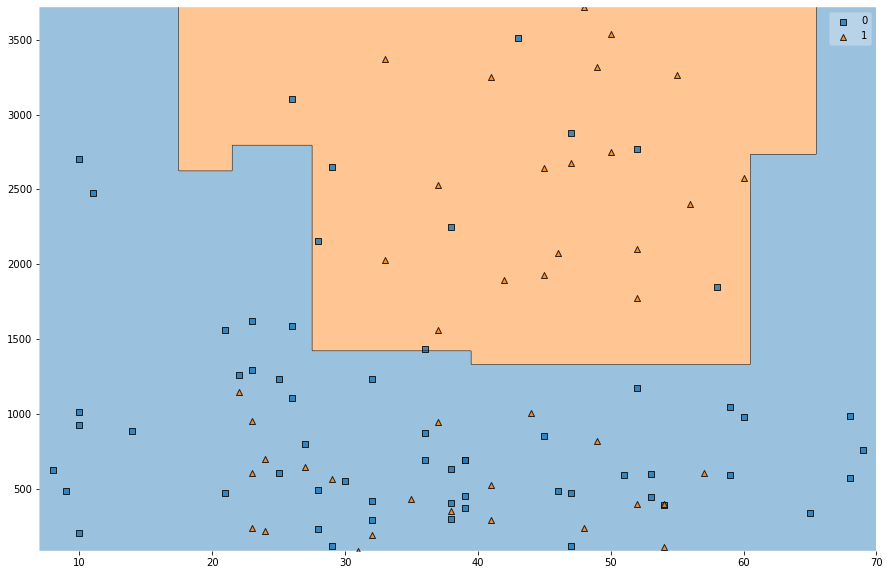

In [ ]:
# your line of code
plt.figure(figsize=(15,10))
plot_decision_regions((X_val_new_con).values[:100], y_val.values[:100], dtc_new_con)
plt.show()

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


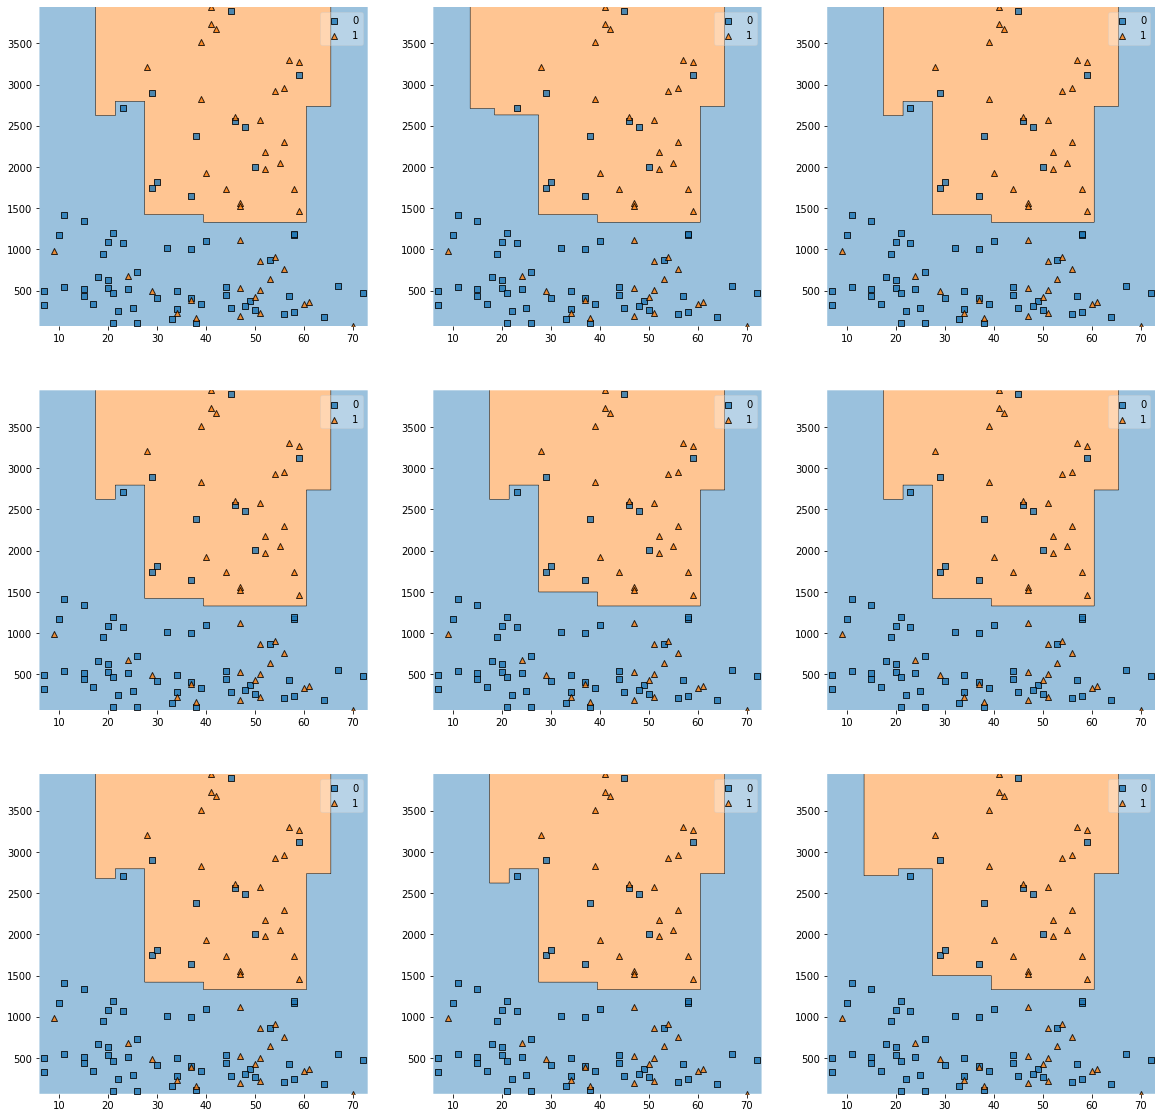

In [ ]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_new_con.index, size=X_train_new_con.shape[0] - 1000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_new_con.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_new_con.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# change X_train_enc into your ohe-encoded train set

%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 5.67 s, sys: 13.6 ms, total: 5.68 s
Wall time: 5.74 s


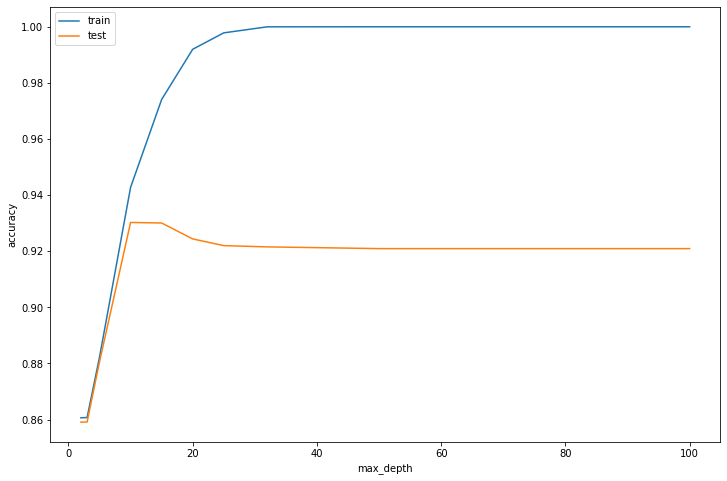

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font>. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [ ]:
# you know what to do
params = {'max_depth' : np.arange(2, 12),
          'ccp_alpha': np.arange(0,1,0.1),
          'min_samples_leaf': np.arange(1,50,2),
          'max_features' : ["auto", "sqrt", "log2"]}

In [ ]:
gs = GridSearchCV(dtc, params, scoring='accuracy', cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_
# {'ccp_alpha': 0.0,
#  'max_depth': 11,
#  'max_features': 'log2',
#  'min_samples_leaf': 1}

In [ ]:
tree_test = DecisionTreeClassifier(ccp_alpha=0.0, max_depth=11, min_samples_leaf=1, max_features= 'log2')

In [ ]:
tree_test.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, max_features='log2')

In [ ]:
accuracy_score(y_train, tree_test.predict(X_train))
# 0.9217650879641787

0.9217650879641787

In [ ]:
accuracy_score(y_val, tree_test.predict(X_val))
# 0.9106123633549386

0.9106123633549386

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(tree_test, f)

# Random Forest (2 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [ ]:
# -__-
%%time
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
accuracy_score(y_val, random_forest.predict(X_val))

# CPU times: user 7.39 s, sys: 63 ms, total: 7.45 s
# Wall time: 7.5 s
# 0.943084711876431

CPU times: user 10.8 s, sys: 52 ms, total: 10.8 s
Wall time: 10.9 s


0.943084711876431

(0.25 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

<Figure size 720x720 with 0 Axes>

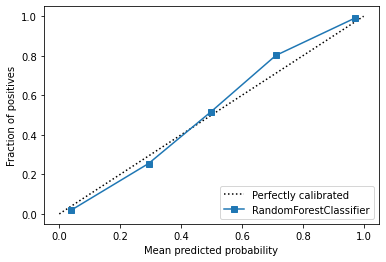

In [ ]:
# some lines of your code
fig = plt.figure(figsize=(10, 10))
display = CalibrationDisplay.from_estimator(
        random_forest,
        X_val,
        y_val,
        n_bins=5)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown



<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

accuracy logistic regression: 0.8237722098610171


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<Figure size 720x720 with 0 Axes>

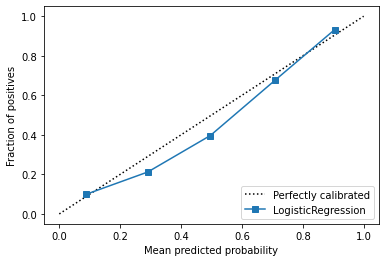

In [ ]:
# --____--
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(r'accuracy logistic regression: {}'.format(accuracy_score(y_val, log_reg.predict(X_val))))

fig = plt.figure(figsize=(10, 10))
display = CalibrationDisplay.from_estimator(
        log_reg,
        X_val,
        y_val,
        n_bins=5,)


Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

потому что под капотом сигмоида: 

$
F(ϴ, x) = \frac {1}{1 - exp^-(ϴx)}
$

соответственно сигмоида преводит область значений в промежуток (0,1)

In [ ]:
# maths needed

(0.25 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.tree import DecisionTreeClassifier

<Figure size 720x720 with 0 Axes>

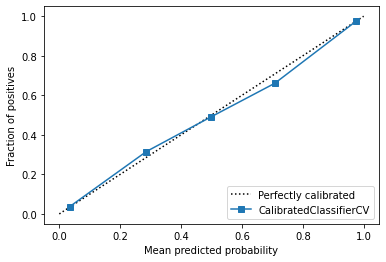

In [ ]:
# yet another code cell for logreg

random_forest_sigmoid = CalibratedClassifierCV(random_forest, cv=5, method="sigmoid")
random_forest_sigmoid.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 10))

display = CalibrationDisplay.from_estimator(
        random_forest_sigmoid,
        X_val,
        y_val,
        n_bins=5)

<Figure size 720x720 with 0 Axes>

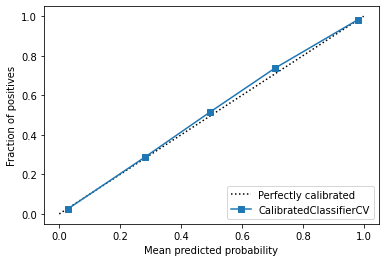

In [ ]:
# yet another code cell for isoreg
random_forest_isotonic = CalibratedClassifierCV(random_forest, cv=5, method="isotonic")

random_forest_isotonic.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 10))

display = CalibrationDisplay.from_estimator(
        random_forest_isotonic,
        X_val,
        y_val,
        n_bins=5)

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# feel free to change this cell into markdown



(0.25 балла) <font color='#9933CC'>Посчитайте разброс и смещение полученной композиции.</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [ ]:
# one more place for your code
%%time
error_dt_isot, bias_dt_isot, var_dt_isot = bias_variance_decomp(random_forest_isotonic, X_train=X_train.values, y_train=y_train.values, X_test=X_val.values, y_test=y_val.values, loss='0-1_loss',random_seed=42)
error_dt_isot, bias_dt_isot, var_dt_isot

# CPU times: user 2h 10min 36s, sys: 11.9 s, total: 2h 10min 48s
# Wall time: 2h 11min 19s
# (0.05949485666376447, 0.05794718003289155, 0.010524491309535327)

CPU times: user 2h 10min 36s, sys: 11.9 s, total: 2h 10min 48s
Wall time: 2h 11min 19s


(0.05949485666376447, 0.05794718003289155, 0.010524491309535327)

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [ ]:
# (•_•)
%%time
error_dt_log, bias_dt_log, var_dt_log = bias_variance_decomp(random_forest_sigmoid, X_train=X_train.values, y_train=y_train.values, X_test=X_val.values, y_test=y_val.values, loss='0-1_loss',random_seed=42)
error_dt_log, bias_dt_log, var_dt_log

# CPU times: user 2h 11min 1s, sys: 2min 13s, total: 2h 13min 15s
# Wall time: 2h 11min 42s
# (0.05932104737028797, 0.05778594692205991, 0.010203959885202025)

CPU times: user 2h 11min 1s, sys: 2min 13s, total: 2h 13min 15s
Wall time: 2h 11min 42s


(0.05932104737028797, 0.05778594692205991, 0.010203959885202025)

(0.25 балла) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import uniform

In [ ]:
uniform.cdf(range(2, 12), loc=2, scale=1)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# your code here
random_forest_isotonic.get_params()
random_forest_sigmoid.get_params()

{'base_estimator__bootstrap': True,
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': 'auto',
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__max_samples': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__n_estimators': 100,
 'base_estimator__n_jobs': None,
 'base_estimator__oob_score': False,
 'base_estimator__random_state': None,
 'base_estimator__verbose': 0,
 'base_estimator__warm_start': False,
 'base_estimator': RandomForestClassifier(),
 'cv': 5,
 'ensemble': True,
 'method': 'sigmoid',
 'n_jobs': None}

In [ ]:
distributions = {'base_estimator__max_depth' : np.arange(2, 12),
          'base_estimator__ccp_alpha': uniform.cdf(range(0, 10), loc=1, scale=10),
          'base_estimator__min_samples_leaf': np.arange(1,50,2),
          'base_estimator__max_features' : ["auto", "sqrt", "log2"]}

In [ ]:
clf = RandomizedSearchCV(random_forest_sigmoid, distributions, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_
# {'base_estimator__min_samples_leaf': 17,
#  'base_estimator__max_features': 'log2',
#  'base_estimator__max_depth': 5,
#  'base_estimator__ccp_alpha': 0.0}

{'base_estimator__min_samples_leaf': 17,
 'base_estimator__max_features': 'log2',
 'base_estimator__max_depth': 5,
 'base_estimator__ccp_alpha': 0.0}

In [ ]:
%%time
random_forest_best = RandomForestClassifier(min_samples_leaf=17, max_features='log2', max_depth=5, ccp_alpha=0.0)

random_forest_best.fit(X_train, y_train)
accuracy_score(y_val, random_forest_best.predict(X_val))
# CPU times: user 5.1 s, sys: 24.5 ms, total: 5.13 s
# Wall time: 6.42 s
# 0.9027441875463545

CPU times: user 5.1 s, sys: 24.5 ms, total: 5.13 s
Wall time: 6.42 s


0.9027441875463545

<img src=''>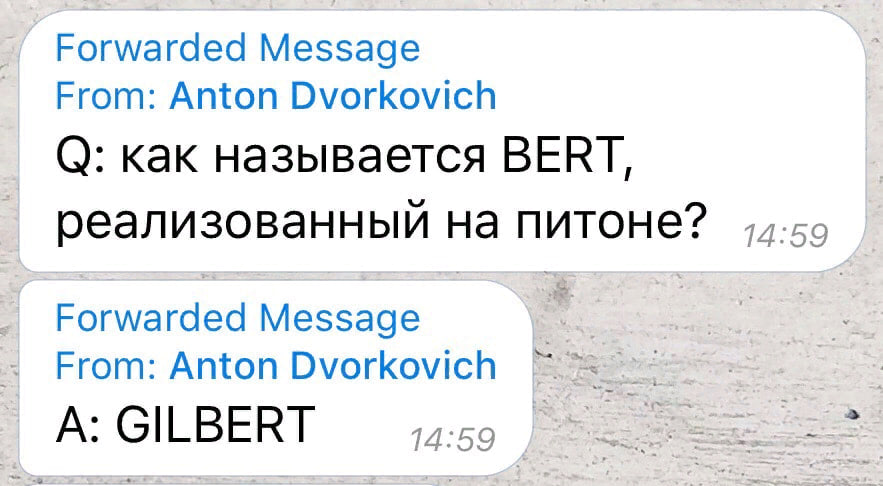

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
X_train_enc = X_train

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


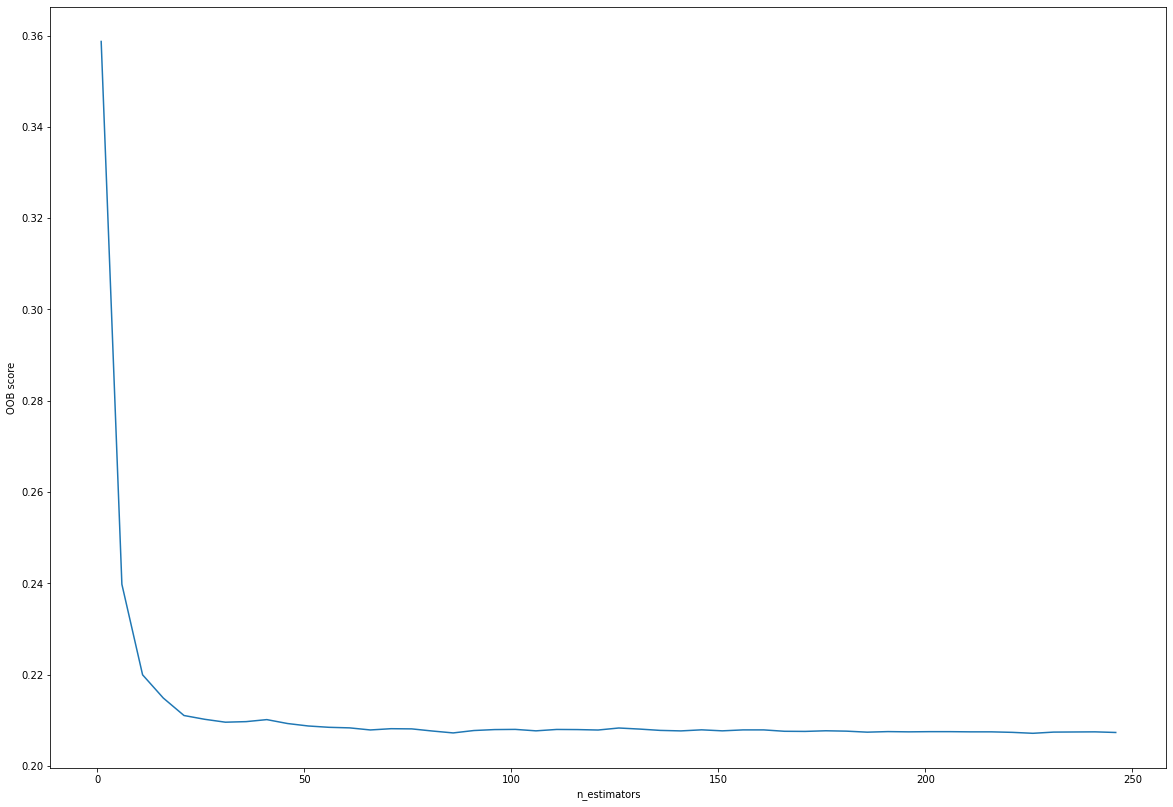

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

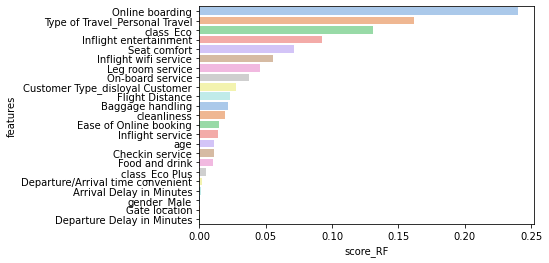

In [ ]:
# (•_•)
# the place for your code
df_features = pd.DataFrame(random_forest_best.feature_importances_,columns=['score_RF'])
features = pd.DataFrame(X_train.columns,columns=['features'])
features = features.join(df_features, how='right')
features.sort_values(by='score_RF', ascending=False, inplace=True)
sns.barplot(
    data=features,
    x="score_RF",
    y="features",
    capsize=.4,
    palette ="pastel")

(0.25 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [ ]:
# -__-

(0.25 балла) <font color='#9933CC'>Оцените Permutation Importance вашео случайного леса</font>. Загляните в [документацию библиотеки eli5](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
# your code
per_importance = PermutationImportance(random_forest_best, scoring=None, n_iter=5, random_state=None, cv='prefit', refit=True)

In [ ]:
per_importance.fit(X_train, y_train)

PermutationImportance(estimator=RandomForestClassifier(max_depth=5,
                                                       max_features='log2',
                                                       min_samples_leaf=17))

In [ ]:
per_importance.feature_importances_

array([ 1.39305408e-03,  2.03513039e-02,  5.36215260e-04,  6.37930320e-03,
       -3.86959466e-05, -4.67115355e-04,  6.28477453e-02,  7.68943739e-03,
        9.21516328e-03,  6.74691469e-03,  6.67781478e-03,  2.23883691e-03,
        2.12274907e-03,  2.11169309e-03,  2.83586009e-03, -2.15591702e-04,
        7.73918932e-05,  1.18851836e-04,  3.31679542e-05,  6.81325060e-03,
        9.58968477e-02,  1.23688829e-02, -2.76399619e-06])

<font color='#FF6600'>Изучите документацию библиотеки eli5. Перечислите полезные инструменты из неё, которые вам хотелось бы попробовать: </font>

In [ ]:
# feel free to change this cell into markdown



(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
import shap
shap.initjs()

In [ ]:
indx = np.random.choice(X_val.index, 100)
X_val_SHARP_LIME = X_val.loc[indx, :]

In [ ]:
feature_results = pd.DataFrame({'feature': list(X_train.columns), 
                                'importance': per_importance.feature_importances_})
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

most_important_features = feature_results['feature'][:10]

In [ ]:
# (•_•)
gb_explainer = shap.KernelExplainer(random_forest_best.predict, c)
gb_shap_values = gb_explainer.shap_values(X_val_SHARP_LIME)

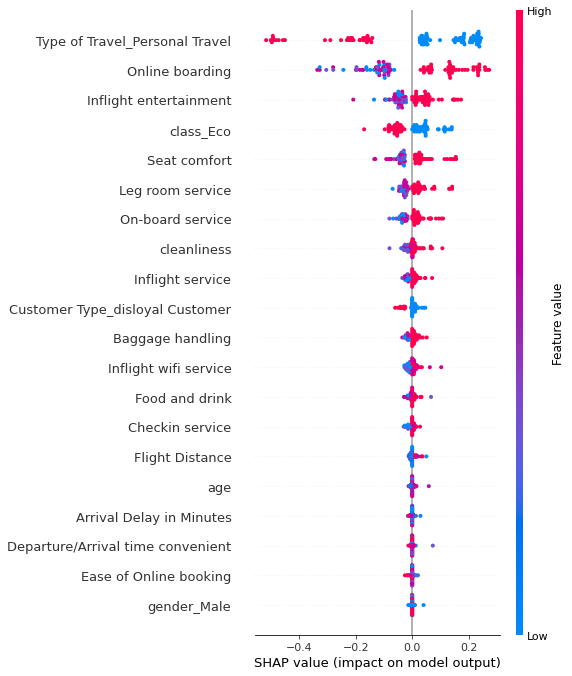

In [ ]:
shap.summary_plot(gb_shap_values, X_val_SHARP_LIME, feature_names = list(X_train.columns))

<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown



(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
# please type your solution below



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


CPU times: user 13 s, sys: 918 ms, total: 13.9 s
Wall time: 16.1 s


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное дерево, дающее лучший скор, сохраните в pickle</font>

# Бустинги (1 балл)

## CatBoost (0.25 балла)

(0.25 балла) <font color='#9933CC'>Обучите pipeline из стандартизации континуальных (как договаривались) признаков и `CatBoostClassifier` с параметрами по умолчанию</font>. `StandardScaler` из sklearn не подойдет. Напишите свой собственный, который не будет изменять остальные фичи.

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns.drop('satisfaction')) 

In [ ]:
class MyStandardScaler(TransformerMixin):
    '''A template for a custom transformer.'''
    def __init__(self, cols, scaler=None, estimator=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
        self.estimator = estimator or CatBoostClassifier()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

    def predict(self, X, y):
        X_transform = self.transform(X)
        self.estimator.fit(X_transform, y)
        return self.estimator.predict(X_transform)

In [ ]:
%%time
p1 = Pipeline([
    ('scaler_', MyStandardScaler(continuous_cols)),
    ('model_', CatBoostClassifier())
    ])

CPU times: user 710 µs, sys: 0 ns, total: 710 µs
Wall time: 723 µs


In [ ]:
%%time
# cell for pipeline fit and predict
p1.fit(X_train, y_train)

# CPU times: user 40.8 s, sys: 3.83 s, total: 44.7 s
# Wall time: 29.7 s
# Pipeline(steps=[('scaler_',
#                  <__main__.MyStandardScaler object at 0x7f4c5f9098b0>),
#                 ('model_',
#                  <catboost.core.CatBoostClassifier object at 0x7f4c5ce2ca00>)])

In [ ]:
%%time
y_pred = p1.predict(X_val)

# CPU times: user 85.3 ms, sys: 4.82 ms, total: 90.1 ms
# Wall time: 105 ms

CPU times: user 85.3 ms, sys: 4.82 ms, total: 90.1 ms
Wall time: 105 ms


In [ ]:
%%time
accuracy_score(y_val, y_pred)
# CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
# Wall time: 18.6 ms
# 0.951049627551514

CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
Wall time: 18.6 ms


0.951049627551514

<font color='#9933CC'>Сохраните себе `feature_importances_` катбуста</font>. Дальше они вам пригодятся

In [ ]:
# (•_•)
p1.get_params()['model_'].feature_importances_

# array([ 5.3175349 , 27.60073294,  0.89521234,  2.80348757,  5.08331993,
#         1.06776509, 11.0615692 ,  2.16854016,  3.58963312,  1.34048624,
#         3.17116212,  2.64867525,  1.27656962,  2.18125896,  1.27967283,
#         2.48160982,  0.60997619,  1.20846937,  0.51840811,  5.65805521,
#        13.7381169 ,  3.45708864,  0.8426555 ])

array([ 5.3175349 , 27.60073294,  0.89521234,  2.80348757,  5.08331993,
        1.06776509, 11.0615692 ,  2.16854016,  3.58963312,  1.34048624,
        3.17116212,  2.64867525,  1.27656962,  2.18125896,  1.27967283,
        2.48160982,  0.60997619,  1.20846937,  0.51840811,  5.65805521,
       13.7381169 ,  3.45708864,  0.8426555 ])

## XGBoost + optuna (0.5 балла)

<font color='#9933CC'>Обучите `XGBClassifier` с параметрами по умолчанию</font>

In [ ]:
# -___-
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier()

In [ ]:
accuracy_score(y_val, xgb.predict(X_val))

0.9183837992970236

(0.5 балла) <font color='#9933CC'>Оптуной подберите лучшие гиперпараметры для XGBoost</font> 

Полезные ссылки: [тык1](https://optuna.readthedocs.io/en/stable/), [тык2](https://habr.com/ru/post/704432/)

In [ ]:
!pip install optuna

In [ ]:
import optuna
import xgboost as xgb

In [ ]:
import sklearn

In [ ]:
# (•_•) первичный код по этой ссылке https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImI0OWM1MDYyZDg5MGY1Y2U0NDllODkwYzg4ZThkZDk4YzRmZWUwYWIiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NzYxMjkxNDAsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwNzEyMTU3NDQ2NjQ1NDU2MTkzMyIsImVtYWlsIjoiYWxnYXJpdG1ubzgyMkBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXpwIjoiMjE2Mjk2MDM1ODM0LWsxazZxZTA2MHMydHAyYTJqYW00bGpkY21zMDBzdHRnLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tIiwibmFtZSI6ItCQ0LvQtdC60YHQtdC5INCb0LgiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUVkRlRwN0pRU2pkS1FXenNmSHpOYlJhWnMxZWo0cnlFOTBHVXJQc25DOU09czk2LWMiLCJnaXZlbl9uYW1lIjoi0JDQu9C10LrRgdC10LkiLCJmYW1pbHlfbmFtZSI6ItCb0LgiLCJpYXQiOjE2NzYxMjk0NDAsImV4cCI6MTY3NjEzMzA0MCwianRpIjoiMjdjMDNjYTFhYWU1MWYxMmRkYzk4OTBjMDQxMzNmNjlkZTZmY2VlNSJ9.mglJ03-ACZBVUCiVof2W_lsJzyCZi0XEIqzkmTabLwNgouEE4Y3nH7god5SuE3SnZSpCtGbWYzVE3jCC91nYhkS4_0RhIRfRSVvbBNZKieLIQDjCs80tdi5NyQyjjqLVE4-yEdi1Ia-M_JoU35SLjszxGH5-ArP4L5E3Azr3T20Wd9eQZyXz-kBO7O-BwZ3inbMin0tA_dbAnNWIS4iq1KLqKkLM_8Kl7hUrx90zfk_Q4jN_wC9rUrcNH3SaQ4eB8Njx72P7uD68W-Tm3XWbsPBf7Ij-Q8gyW5Vs1mN2A5WStO-KURCgQf28EQd-bRfU6u7wH7AJkNQy_qroEpyFIQ
def objective(trial):
    # data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dtest = xgb.DMatrix(X_val.values, label=y_val.values)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 40)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val.values, pred_labels)
    return accuracy


In [ ]:
%%time
# study = optuna.create_study(study_name="xgboost", direction='maximize')
study = optuna.create_study()
study.optimize(objective, n_trials=10)

# CPU times: user 21.6 s, sys: 150 ms, total: 21.8 s
# Wall time: 22 s

<font color='#9933CC'>Обучите XGBClassifier c подобранными гиперпараметрами</font>

In [ ]:
# code below
xgb_best = XGBClassifier(
    **study.best_params,
    random_state=42
)

<font color='#9933CC'>Сохраните себе `feature_importances_` xbgoost'а</font>. Дальше они вам пригодятся

In [ ]:
%%time
# code here
xgb_best.fit(X_train, y_train)

# CPU times: user 2.82 s, sys: 24.8 ms, total: 2.85 s
# Wall time: 2.86 s
# XGBClassifier(alpha=0.03797285705400098, booster='gblinear',
#               lambda=1.3585465458355824e-08, random_state=42)

CPU times: user 2.82 s, sys: 24.8 ms, total: 2.85 s
Wall time: 2.86 s


XGBClassifier(alpha=0.03797285705400098, booster='gblinear',
              lambda=1.3585465458355824e-08, random_state=42)

In [ ]:
accuracy_score(y_val, xgb_best.predict(X_val))

0.7377382219212537

In [ ]:
xgb_best.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=0.03797285705400098, booster='gblinear',
              lambda=1.3585465458355824e-08, random_state=42)>

## LightGBM + Pipeline (0.25 балла)

(0.25 балла) И наконец, <font color='#9933CC'>обучите пайплайн из стандартизации признаков "Age" и "FlightDistance",  нормализации фичей "log_arrival_delay" и "log_departure_delay" и `LGBMClassifier` с параметрами по умолчанию</font>. Вам снова понадобится свой кастомный Scaler, который не будет трогать остальные фичи

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class MyMinMaxScaler(TransformerMixin):
    '''A template for a custom transformer.'''
    def __init__(self, cols, scaler=None, estimator=None):
        self.cols = cols
        self.scaler = scaler or MinMaxScaler()
        self.estimator = estimator or CatBoostClassifier()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

    def predict(self, X, y):
        X_transform = self.transform(X)
        self.estimator.fit(X_transform, y)
        return self.estimator.predict(X_transform)

In [ ]:
class MyStandardScaler(TransformerMixin):
    '''A template for a custom transformer.'''
    def __init__(self, cols, scaler=None, estimator=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
        self.estimator = estimator or CatBoostClassifier()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

    def predict(self, X, y):
        X_transform = self.transform(X)
        self.estimator.fit(X_transform, y)
        return self.estimator.predict(X_transform)

In [ ]:
pipe = [
    ('std_scaling', MyStandardScaler(cols=['age', "Flight Distance"])),
    ('min_max', MyMinMaxScaler(cols=['Arrival Delay in Minutes', 'Departure Delay in Minutes'])),
    ('lgbm', LGBMClassifier())
]
lgbm_pipeline = Pipeline(pipe)

# your solution goes below
# cell for pipeline fit and predict
lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
accuracy_score(y_val, y_pred)
# 0.9478572119570475

0.9478572119570475

<font color='#9933CC'>Сохраните себе `feature_importances_` lgbm'а</font>. Дальше они вам пригодятся

In [ ]:
# code here
lgbm_pipeline.get_params()['lgbm'].feature_importances_

array([286, 453,  56, 131, 143,  60, 177, 125, 116,  60, 124, 137,  81,
       108,  72, 175,  43,  86,  33, 148, 177, 148,  61])

In [ ]:
lgbm_pipeline.get_params()['lgbm']

LGBMClassifier()

<font color='#9933CC'>Сохраните получившиеся бустинги (лучший xgboost, lgmb и catboost) в pickle</font>

<img src='https://i.imgur.com/qBFSCjZ.jpg' height=500px>

In [ ]:
# your code below
file_name_xgboost_best = "xgboost_best.pkl"
file_name_lgmb_best = "lgmb_best.pkl"
file_name_catboost_best = "catboost_best.pkl"

pickle.dump(xgb, open(file_name_xgboost_best, "wb"))
# 0.9183837992970236
pickle.dump(lgbm_pipeline.get_params()['lgbm'], open(file_name_lgmb_best, "wb"))
# 0.9478572119570475
pickle.dump(p1.get_params()['model_'], open(file_name_catboost_best, "wb"))
# 0.951049627551514

# Стекинг (0.5 балла)

(0.25 балла) <font color='#9933CC'>Воспользуйтесь `StackingClassifier` из skearn для ансаблирования обученных вами к этому шагу моделей</font>

In [ ]:
# code here
%%time


<font color='#9933CC'>Посмотрим, откалиброваны ли полученные после стекинга вероятности</font>

In [ ]:
# -__-

Неожиданно хорошо. Не так ли?

(0.25 балла) <font color='#9933CC'>Постройте ROC- и PR-кривые для полученной композиции. Также выведите другие метрики классификации: F1-score, precision, recall

In [ ]:
# the place for your solution



# Aftermath (1 балл)

В этом домашнем занятии до настоящей ячейки вы обучали модели на всех признаках из обучающей выборки. Давайте под конец попробуем избавиться от признаков, минимально влияющих на результат

Мы довольно часто выводили `feature_importances_` алгоритмов. Пробовали интерпретировать предсказания модели SHAP'ом. Неплохо бы структурировать и валидировать полученные знания.

(0.25 балла) <font color='#9933CC'>Создайте таблицу, в которой для сохраненных вами pickle'ом классификаторов в соответсвующих столбцах будут отранжированные по убыванию `feature_importances_` для этого конкретного классификатора.</font>

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [ ]:
# (•_•)



<font color='#FF6600'>Сделайте выводы: какие 3 признака скорее всего можно удалить?</font>

(0.25 балла) <font color='#9933CC'>Далее для отбора признаков воспользуемся статистическими тестами</font>. Попробуйте отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов примените (отдельно) `chi2` и `mutual_info_classif` 

In [ ]:
# (•_•)



<font color='#FF6600'>Согласуются ли списки признаков-кандитатов на удаление?</font>

In [ ]:
# fell free to change this cell into markdown



(0.25 балла)<font color='#9933CC'>Теперь применим жадные методы отбора признаков</font>. Воспользуйтесь классом `RFECV` для этого. <font color='#FF6600'>Сколько признаков были отобраны как наиболее информативные? Перечислите предложенные к удалению.</font>

In [ ]:
# -____-



(0.25 балла) <font color='#9933CC'>C помощью логистической регрессией с L1-регуляризацией отберите >=5 неифнормативных признака</font>.

In [ ]:
# -____-



<font color='#9933CC'>Удалите 4 признака, которые считаете нужным удалить</font> <font color='#FF6600'>(если хотите больше -- пожалуйста, только обоснуйте целесообразность)</font>. <font color='#9933CC'>Обучите RandomForestClassifier с параметрами по умолчанию на этих признаках</font>. <font color='#FF6600'>Сильно ли уменьшилось качество на валидационной выборке? О чем это говорит?</font>

In [ ]:
# -___-



## Могли попросить, но не попросили (0 баллов, но >0 пользы).

Это домашнее задание уже получилось довольно объемным. Нам хотелось бы добавить ещё несколько (вообще говоря много) заданий -- однако хватит. Ниже некоторые из невошедших заданий

<font color='#29ab87'>На свое усмотрение выберите несколько (>= 3) классификаторов. На кросс-валидации переберите для каждого из них несколько (>=4) значений одного гиперпараметра. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра. На этом же графике изобразите доверительный интервал `[mean - std; mean + std]`</font>

<font color='#29ab87'>Для любой из модификаций бустинга (выберите себе по душе) постройте график ошибки композиции в зависимости от числа деревьев. Подберите гиперпараметр `n_estimators` по этому графику и обоснуйте свой выбор. Какую форму имеет получившаяся у вас ошибка на тесте? Согласуется ли это с теорией?</font>

<font color='#29ab87'>На модельном примере (для 2-х наиболее информативных "континуальных" признаков датасета этой домашки) покажите, как усложняется разделяющая поверхность композиции деревьев бустингом при добавлении в неё нового базового алгоритма, исправляющего ошибку предыдущего ансамбля</font>

<font color='#29ab87'>Постройте решающее дерево без каких-либо ограничений. Посчитайте качество на трейне и валидации. Сравнив их, сделайте выводы о переобучении. Примените какой-нибудь из методов pruning'а. Как изменилось дерево после разреживания (насколько меньше стало листов, изменилась ли глубина и пр.)? Сильно ли упало качество на трейне? Удалось ли перебороть переобучение?

# SQL INSERT (0.25 балла + 0.5)

В схеме `results` базы данных `db_flights` создано две таблицы:

1) `student_results` со столбцами:

```
* name (text)
* surname (text)
* best_algorithm (text)
* cv_score_best_algorithm (numeric(8,5))
* time_fit_best_algorithm (numeric(8,5))
* time_predict_best_algorithm (numeric(8,5))
```



2) `student_predictions` со столбцами:
```
* surname (text)
* id (integer)
* prediction (boolean)
```

У вас есть только возможность вставить данные в таблицу (INSERT), других прав на эту таблицу у вас нет.

**Задание 1 (0.25 балла), БЛОК!!!** <font color='#9933CC'> Вставьте одну строку в таблицу `student_results`, содержащую ваше имя, фамилию, название лучшего сработавшего у вас алгоритма, качество (accuracy) этого алгоритма на кросс-валидации, время обучения алгоритма и время применения алгоритма.</font>

**Задание 2 (0.5 балла), бонус** <font color='#9933CC'> Вставьте в таблицу `student_predictions` предсказания вашей наилучшей модели на тестовых данных. Число строк должно быть равно числу объектов в тестовых данных. В каждой строке столбца `surname` должна быть ваша фамилия, в столбце `id` - id объекта из тестовой выборки, в столбце `prediction` - предсказание вашей лучшей модели (класс).</font>


In [7]:
import traceback

In [13]:
# your code below
try:
    conn = psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
                            port='6432',
                            sslmode='verify-full',
                            dbname='db_flights', 
                            user='mlhs_student', 
                            password='mlhs_student',                          
                            target_session_attrs='read-write')
    with conn.cursor() as cur:
        cur.execute("INSERT INTO results.student_results (name, surname, best_algorithm, cv_score_best_algorithm,time_fit_best_algorithm, time_predict_best_algorithm) VALUES ('Alexey', 'Litovchenko', 'catboost_best', 0.95104,29.7, 18.5)")
except Exception as exception:
    print("Exception: {}".format(type(exception).__name__))
    print("Exception message: {}".format(exception))
finally:
    if conn:
        conn.commit()
        conn.close()
        print("[INFO] PostgreSQL closed")

[INFO] PostgreSQL closed


<img src='https://avatars.mds.yandex.net/get-images-cbir/1624848/cc-ejKx9OmtUbvaWx4cTNw1262/ocr' height=500px>

# Бонусная (+ 2.5 балла)

(0.5 балла) <font color='#9933CC'>Попробуйте различные знакомые вам подходы к  feature engineering</font>.

* Некоторые признаки возможно стоит бинаризовать. 
* Заполнять пропуски можно по-другому (умнее, чем мы сделали в начале)
* Можно добавить полиномы и другие фичи, попробовать воспользоваться методами снижения размерности и перейти в другое пространство признаков

*Известно, что скоррелированные признаки -- большая проблема почти для всех моделей машинного обучения. Значит, для стекинга важно, чтобы ответы базовых алгоритмов поменьше коррелировали между собой. Отчасти добиться этого можно добавлением в стекинг моделей разной природы. На соревнованиях по анализу табличных данных, например, в стекинг добавляют в т.ч. нейронные сети.*

(0.5 балла) <font color='#9933CC'>Добавьте в стекинг линейные и др. известные вам модели</font>. Не забудьте, что для них требуются другие пайплайны. Например, стандартизация признаков для деревянных моделей зачастую бессмысленна. Чего нельзя сказать о моделях линейных. <font color='#FF6600'>Позволил ли стекинг повысить качество по сравнению с лучшей его базовой моделью?</font>

(до 1.5 балла) <font color='#9933CC'>По 0.1 балла за каждую тысячную в скоре выше 0.962.</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?